# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels as sm

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [3]:
# Run this code:

sensor = pd.read_csv('sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [4]:
sensor.head(1)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.77818,1.082764,0.294894,-0.184493,0.377542


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
sensor.isnull().sum().sum()

0

How many rows and columns are in our data?

In [6]:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
# create variable with the start and end dates
start = '1/1/2018 00:00:00'
end = '1/1/2018 00:29:10'

In [8]:
# use date_range() to create a range of dates
infer = pd.date_range(start, end, freq='S')

Assign the time series index to the dataframe's index.

In [9]:
# assign the infer range of dates to sensor's index
sensor.index = infer

In [10]:
sensor.head(1)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.77818,1.082764,0.294894,-0.184493,0.377542


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

userAcceleration_sd = seasonal_decompose(sensor['userAcceleration.x'], freq=60)

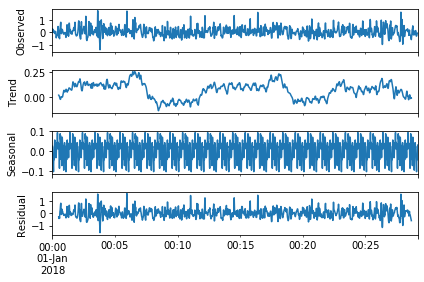

In [12]:
userAcceleration_sd.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

rotationRate_sd = seasonal_decompose(sensor['rotationRate.x'], 
                                     freq=60,
                                    model='additive')


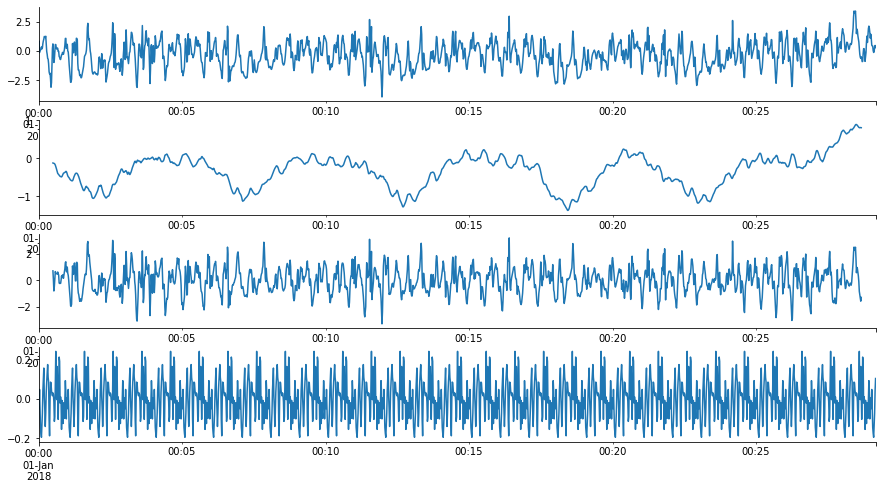

In [14]:
import matplotlib.pyplot as plt 

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8));
rotationRate_sd.observed.plot(ax=ax1);
rotationRate_sd.trend.plot(ax=ax2);
rotationRate_sd.resid.plot(ax=ax3);
rotationRate_sd.seasonal.plot(ax=ax4);

sns.despine()
#rotationRate_sd.plot();

### Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

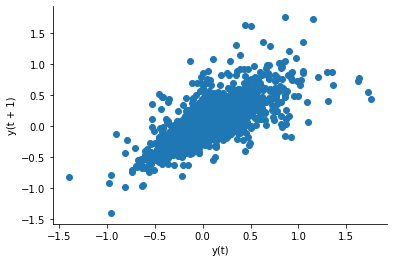

In [16]:
# load function
from pandas.plotting import lag_plot

lag_plot(sensor['userAcceleration.x'])
sns.despine()

Create a lag plot for `rotationRate.x`

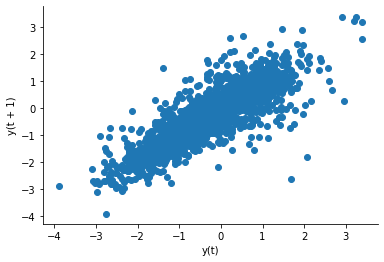

In [17]:
lag_plot(sensor['rotationRate.x'])
sns.despine()

What are your conclusions from both visualizations?

* __'rotationRate.x' and 'userAcceleration.x'__, have presented positive correlation with observations at time t+1

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

* Augumented Dickey Fuller is a hypothesis test. Let's start by writing it:
> * H0: non-stationary
> * H1: stationery

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [19]:
adf_test(sensor['userAcceleration.x'], 'userAcceleration')

Augmented Dickey-Fuller Test: userAcceleration
ADF test statistic     -1.795799e+01
p-value                 2.823439e-30
# lags used             4.000000e+00
# observations          1.746000e+03
critical value (1%)    -3.434101e+00
critical value (5%)    -2.863197e+00
critical value (10%)   -2.567652e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


What are your conclusions from this test?

In [351]:
adf_test(sensor['rotationRate.x'], 'rotationRate.x')

Augmented Dickey-Fuller Test: rotationRate.x
ADF test statistic        -5.269861
p-value                    0.000006
# lags used               25.000000
# observations          1725.000000
critical value (1%)       -3.434147
critical value (5%)       -2.863217
critical value (10%)      -2.567663
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

#### assumption for AR model
1. Stationarity
2. Invertibility

In [327]:
from statsmodels.tsa.arima_model import ARMA 

In [336]:
# split data into train and test
train = sensor['userAcceleration.x'].iloc[:-10, ]
test = sensor['userAcceleration.x'].iloc[-10:, ]

In [352]:
# instantiate the model
model_ar = ARMA(train, order=(2,1))

# fit the model
model_ar_fit = model_ar.fit(disp=False)

predict = model_ar_fit.predict(len(sensor)-10,
                              len(sensor)-1)

In [354]:
len(sensor)-10

1741

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [334]:
from statsmodels.tools.eval_measures import rmse

In [338]:
rmse(predict, test)

0.22529864612787218

In [339]:
pd.DataFrame({'observed':test, 'predictions': predict})

,observed,predictions
2018-01-01 00:29:01,0.149749,0.173149
2018-01-01 00:29:02,0.038461,0.142896
2018-01-01 00:29:03,-0.169175,0.100522
2018-01-01 00:29:04,-0.300361,0.070106
2018-01-01 00:29:05,-0.270174,0.056099
2018-01-01 00:29:06,-0.268367,0.053778
2018-01-01 00:29:07,-0.102444,0.056790
2018-01-01 00:29:08,-0.085590,0.060646
2018-01-01 00:29:09,-0.048105,0.063316
2018-01-01 00:29:10,-0.065011,0.064493


In [ ]:
df.resample()